In [1327]:
import pandas as pd

df1 = pd.read_csv('./data/E2023-2024.csv')
df2 = pd.read_csv('./data/E2022-2023.csv')
df3 = pd.read_csv('./data/E2021-2022.csv')
df4 = pd.read_csv('./data/E2020-2021.csv')
df5 = pd.read_csv('./data/E2019-2020.csv')

all_df = df = pd.concat([df1, df2, df3, df4, df5])


In [1328]:
features = {
     'Date': 'Match Date (dd/mm/yy)',   # merge
     'Time': 'Time of match kick off',  # merge
        
     'HomeTeam': 'Home Team',
     'AwayTeam': 'Away Team',
     # 'Referee': 'Match Referee',
        
     'FTR': 'Full Time Result (H=Home Win, D=Draw, A=Away Win)',  # Y
        
     # 'FTHG': 'Full Time Home Team Goals', # y
     # 'FTAG': 'Full Time Away Team Goals', # y
     # 'HTHG': 'Half Time Home Team Goals',  # y
     # 'HTAG': 'Half Time Away Team Goals',  # y
     # 'HTR': 'Half Time Result (H=Home Win, D=Draw, A=Away Win)',  # y
        
     'B365H': 'Bet365 home win odds',
     'B365D': 'Bet365 draw odds',
     'B365A': 'Bet365 away win odds',
    
}

# has no missing values

#### Utils

In [1329]:
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

def score_model(X_train, X_valid, y_train, y_valid, preprocesor, model=DecisionTreeRegressor, flush=True, **kwargs):
    random_state = kwargs.get('random_state', 0)
    model_tree = model(random_state=random_state, **kwargs)
    
    tree_pipeline = Pipeline(steps=[
        ('preprocesor', preprocesor),
        ('model', model_tree),
    ])
    
    tree_pipeline.fit(X_train, y_train)
    preds = tree_pipeline.predict(X_valid)
    
    mae = mean_absolute_error([round(i) for i in preds], y_valid)
    if flush:
        print(f'\rMAE: {mae} | {kwargs=}', end='', flush=True)
    return mae, preds


def display_plot(x_values, y_values, xlabel: str = '', ylabel: str = '', title: str = '', label: str = 'x'):

    plt.figure(figsize=(6, 3))
    plt.plot(x_values, y_values, linestyle='-', color='b', label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    plt.show()

### Transform

In [1330]:
from datetime import datetime

home = 1
away = 2
draw = 0

X = df5[features.keys()].copy()

X['DateTime'] = pd.to_datetime(X.Date + ' ' + X.Time, format='%d/%m/%Y %H:%M').astype(int) / 100000000000
X = X.sort_values(by='DateTime').reset_index(drop=True)

X.drop('Date', axis=1, inplace=True)
X.drop('Time', axis=1, inplace=True)

# Initialize columns with 0
X['WSH'] = 0
X['DSH'] = 0
X['LSH'] = 0
X['WSA'] = 0
X['DSA'] = 0
X['LSA'] = 0

# Iterate over each row in the DataFrame
for index, row in X.iterrows():
    
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    current_datetime = row['DateTime']
    
    # Subset DataFrame for the home team's last 10 matches before the current match
    last_home_matches = X[(X['HomeTeam'] == home_team) | (X['AwayTeam'] == home_team)]
    last_home_matches = last_home_matches[last_home_matches['DateTime'] < current_datetime].tail(15)
    
    # Subset DataFrame for the away team's last 10 matches before the current match
    last_away_matches = X[(X['HomeTeam'] == away_team) | (X['AwayTeam'] == away_team)]
    last_away_matches = last_away_matches[last_away_matches['DateTime'] < current_datetime].tail(15)

    
    # Calculate WSH, DSH, LSH
    wsh = len(last_home_matches[(last_home_matches['HomeTeam'] == home_team) & (last_home_matches['FTR'] == 'H')]) + \
          len(last_home_matches[(last_home_matches['AwayTeam'] == home_team) & (last_home_matches['FTR'] == 'A')])
    dsh = len(last_home_matches[last_home_matches['FTR'] == 'D'])
    lsh = len(last_home_matches[(last_home_matches['HomeTeam'] == home_team) & (last_home_matches['FTR'] != 'H')]) + \
          len(last_home_matches[(last_home_matches['AwayTeam'] == home_team) & (last_home_matches['FTR'] != 'A')])

    # Calculate WSA, DSA, LSA
    wsa = len(last_away_matches[(last_away_matches['AwayTeam'] == away_team) & (last_away_matches['FTR'] == 'A')]) + \
          len(last_away_matches[(last_away_matches['HomeTeam'] == away_team) & (last_away_matches['FTR'] == 'H')])
    
    dsa = len(last_away_matches[last_away_matches['FTR'] == 'D'])
    lsa = len(last_away_matches[(last_away_matches['AwayTeam'] == away_team) & (last_away_matches['FTR'] != 'A')]) + \
          len(last_away_matches[(last_away_matches['HomeTeam'] == away_team) & (last_away_matches['FTR'] != 'H')])
    
    # Assign the calculated values to the corresponding columns
    X.at[index, 'WSH'] = wsh
    X.at[index, 'DSH'] = dsh
    X.at[index, 'LSH'] = lsh
    
    X.at[index, 'WSA'] = wsa
    X.at[index, 'DSA'] = dsa
    X.at[index, 'LSA'] = lsa
    
    # Calculate and assign time difference for last home and away matches
    if not last_home_matches.empty:
        last_home_match_date = last_home_matches.iloc[-1]['DateTime']
        X.at[index, 'HTR'] = (current_datetime - last_home_match_date)
    else:
        X.at[index, 'HTR'] = None  # No previous home matches

    if not last_away_matches.empty:
        last_away_match_date = last_away_matches.iloc[-1]['DateTime']
        X.at[index, 'ATR'] = (current_datetime - last_away_match_date)
    else:
        X.at[index, 'ATR'] = None  # No previous away matches


print(X[['HomeTeam', 'AwayTeam', 'FTR', 'WSH',  'DSH',  'LSH',  'WSA',  'DSA',  'LSA', 'DateTime', 'HTR', 'ATR']].head(60))

y = X.FTR.replace('H', str(home)).replace('A', str(away)).replace('D', str(draw)).astype(int)
X = X.drop('FTR', axis=1)

num_cols = X.select_dtypes(exclude='object').columns
cat_cols = X.select_dtypes(include='object').columns

            HomeTeam          AwayTeam FTR  WSH  DSH  LSH  WSA  DSA  LSA  \
0          Liverpool           Norwich   H    0    0    0    0    0    0   
1           West Ham          Man City   A    0    0    0    0    0    0   
2        Bournemouth  Sheffield United   D    0    0    0    0    0    0   
3            Burnley       Southampton   H    0    0    0    0    0    0   
4     Crystal Palace           Everton   D    0    0    0    0    0    0   
5            Watford          Brighton   A    0    0    0    0    0    0   
6          Tottenham       Aston Villa   H    0    0    0    0    0    0   
7          Leicester            Wolves   D    0    0    0    0    0    0   
8          Newcastle           Arsenal   A    0    0    0    0    0    0   
9         Man United           Chelsea   H    0    0    0    0    0    0   
10           Arsenal           Burnley   H    1    0    0    1    0    0   
11       Southampton         Liverpool   A    0    0    1    1    0    0   
12          

### Preprocesor

In [1331]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, shuffle=False)

preprocesor = ColumnTransformer(transformers=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1000), cat_cols),
])

model_perfomance = {}

### Mesure Model Perfomance
#### DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

max_leaf_nodes = [None, *list(range(2, 100))]

res = {}
for max_leaf_node in max_leaf_nodes:
    res[max_leaf_node], tree_pred = (score_model(X_train, X_valid, y_train, y_valid, model=DecisionTreeRegressor, preprocesor=preprocesor, max_leaf_nodes=max_leaf_node))

print(min(res.items(), key=lambda item: item[1]))
display_plot(max_leaf_nodes, res.values())

model_perfomance.setdefault('DecisionTreeRegressor', {})
model_perfomance['DecisionTreeRegressor']['max_leaf_nodes'] = min(res.items(), key=lambda item: item[1])

#### RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

max_leaf_nodes = [None, *list(range(2, 50))]

res = {}
for max_leaf_node in max_leaf_nodes:
    res[max_leaf_node], _ = score_model(
        X_train, X_valid, y_train, y_valid, 
        model=RandomForestRegressor, 
        preprocesor=preprocesor, 
        max_leaf_nodes=max_leaf_node,
        flush=False
    )


print(min(res.items(), key=lambda item: item[1]))
display_plot(max_leaf_nodes, res.values())

model_perfomance.setdefault('RandomForestRegressor', {})
model_perfomance['RandomForestRegressor']['max_leaf_nodes'] = min(res.items(), key=lambda item: item[1])

In [ ]:
n_estimators = list(range(2, 150, 5))

res = {}
for n_estimator in n_estimators:
    res[n_estimator], _ = score_model(
        X_train, X_valid, y_train, y_valid, 
        model=RandomForestRegressor, 
        preprocesor=preprocesor, 
        n_estimators=n_estimator,
        flush=True,
    )


print(min(res.items(), key=lambda item: item[1]), sep='\n')
display_plot(n_estimators, res.values())

model_perfomance.setdefault('RandomForestRegressor', {})
model_perfomance['RandomForestRegressor']['n_estimators'] = min(res.items(), key=lambda item: item[1])

In [1208]:
max_leaf_nodes = [None, *list(range(2, 50, 5))]
n_estimators = list(range(2, 75, 5))

res = {}
for max_leaf_node in max_leaf_nodes:
    for n_estimator in n_estimators:
        res[f"{max_leaf_node} {n_estimator}"], _ = score_model(
            X_train, X_valid, y_train, y_valid, 
            model=RandomForestRegressor, 
            preprocesor=preprocesor, 
            max_leaf_nodes=max_leaf_node,
            n_estimators=n_estimator,
            flush=True
        )

print(min(res.items(), key=lambda item: item[1]))

model_perfomance.setdefault('RandomForestRegressor', {})
model_perfomance['RandomForestRegressor']['max_leaf + n_estimators'] = min(res.items(), key=lambda item: item[1])

MAE: 0.5657894736842105 | kwargs={'max_leaf_nodes': 47, 'n_estimators': 72}2}('12 2', 0.4868421052631579)


#### XGBRegressor

MAE: 0.6578947368421053 | kwargs={'n_estimators': 145}(5, 0.5526315789473685)


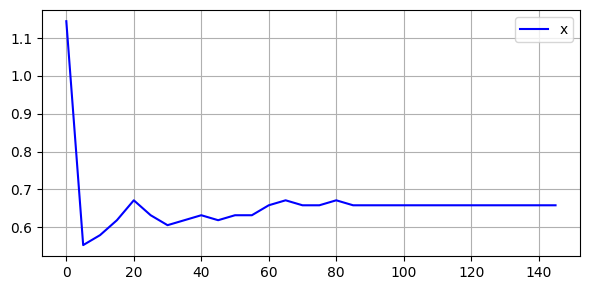

In [1209]:
from xgboost import XGBRegressor


n_estimators = list(range(0, 150, 5))

res = {}
for n_estimator in n_estimators:
    res[n_estimator], _ = score_model(
        X_train, X_valid, y_train, y_valid, 
        model=XGBRegressor, 
        preprocesor=preprocesor, 
        n_estimators=n_estimator,
        flush=True,
    )


print(min(res.items(), key=lambda item: item[1]), sep='\n')
display_plot(n_estimators, res.values())

model_perfomance['XGBRegressor'] = {}
model_perfomance['XGBRegressor']['n_estimators'] = min(res.items(), key=lambda item: item[1])

In [1210]:
import json

print(json.dumps(model_perfomance, indent=4))

{
    "DecisionTreeRegressor": {
        "max_leaf_nodes": [
            7,
            0.47368421052631576
        ]
    },
    "RandomForestRegressor": {
        "max_leaf_nodes": [
            2,
            0.5131578947368421
        ],
        "n_estimators": [
            12,
            0.5263157894736842
        ],
        "max_leaf + n_estimators": [
            "12 2",
            0.4868421052631579
        ]
    },
    "XGBRegressor": {
        "n_estimators": [
            5,
            0.5526315789473685
        ]
    }
}


### Predict

In [1332]:
my_pipeline = Pipeline(
    steps=[
        ('preprocesor', preprocesor),
        ('model', DecisionTreeRegressor(max_leaf_nodes=7, random_state=1)),
    ]
)

my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocesor',
                 ColumnTransformer(transformers=[('ordinal',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=1000),
                                                  Index(['HomeTeam', 'AwayTeam', 'HTR', 'ATR'], dtype='object'))])),
                ('model',
                 DecisionTreeRegressor(max_leaf_nodes=7, random_state=1))])

In [1335]:
# y = _df.FTR.replace('H', '1').replace('A', '2').replace('D', '0').astype(int)
import numpy as np

predictions = my_pipeline.predict(X_valid)

res_df = pd.DataFrame({
    'pred': predictions, 
    'pred_round': [2 if i > 1.1 else round(i)  for i in predictions],
    'valid': y_valid, 
    'D': X_valid.B365D,
    'H': X_valid.B365H, 
    'A': X_valid.B365A
})

res_df['valid_rai'] = np.where(
    res_df['pred_round'] == draw, res_df['D'], 
    np.where(
        res_df['pred_round'] == home, res_df['H'], res_df['A']
    )
)


res_df['my_rai'] = np.where(res_df['pred_round'] == res_df['valid'], abs(100 - (res_df['valid_rai'] * 100)), -100)

print(f"Margin: {res_df.my_rai.sum()}, Won: {(res_df[res_df['my_rai'] > 0]['my_rai']+100).sum()} (100$/bet), Spent {res_df.my_rai.count() * 100} ({(res_df.my_rai > 0).sum()} wins, {(res_df.my_rai < 0).sum()} loses)")
print(res_df.head(55))

print('H:', (res_df.pred_round == home).sum())
print('D:', (res_df.pred_round == draw).sum())
print('A:', (res_df.pred_round == away).sum())


Margin: 2150.0, Won: 9750.0 (100$/bet), Spent 7600 (39 wins, 37 loses)
         pred  pred_round  valid     D      H      A  valid_rai  my_rai
304  1.049180           1      2  3.60   3.90   1.90       3.90  -100.0
305  1.049180           1      1  4.00   1.55   6.00       1.55    55.0
306  1.049180           1      1  6.50   1.22  13.00       1.22    22.0
307  1.250000           2      2  3.50   2.60   2.62       2.62   162.0
308  0.963504           1      1  3.25   3.00   2.45       3.00   200.0
309  0.750000           1      1  4.00   4.00   1.80       4.00   300.0
310  0.963504           1      2  3.70   4.60   1.75       4.60  -100.0
311  0.963504           1      2  3.30   2.50   2.87       2.50  -100.0
312  1.049180           1      2  3.20   2.25   3.40       2.25  -100.0
313  0.963504           1      2  3.80   6.00   1.61       6.00  -100.0
314  0.963504           1      1  4.75   1.44   7.00       1.44    44.0
315  0.963504           1      2  3.10   2.40   3.20       2.40  

In [ ]:
predictions = my_pipeline.predict(X_valid[50:])

res_df = pd.DataFrame({
    'pred': predictions, 
    'pred_round': [2 if i > 1.1 else round(i)  for i in predictions],
    'valid': y_valid, 
    'D': X_valid.B365D,
    'H': X_valid.B365H, 
    'A': X_valid.B365A
})

res_df['valid_rai'] = np.where(
    res_df['pred_round'] == draw, res_df['D'], 
    np.where(
        res_df['pred_round'] == home, res_df['H'], res_df['A']
    )
)


res_df['my_rai'] = np.where(res_df['pred_round'] == res_df['valid'], abs(100 - (res_df['valid_rai'] * 100)), -100)

print(f"Margin: {res_df.my_rai.sum()}, Won: {(res_df[res_df['my_rai'] > 0]['my_rai']+100).sum()} (100$/bet), Spent {res_df.my_rai.count() * 100} ({(res_df.my_rai > 0).sum()} wins, {(res_df.my_rai < 0).sum()} loses)")
print(res_df.head(55))

print('H:', (res_df.pred_round == home).sum())
print('D:', (res_df.pred_round == draw).sum())
print('A:', (res_df.pred_round == away).sum())

In [1273]:
from sklearn.model_selection import cross_val_score

def cross_validate_random_forest(n_estimators, X, y, cv=10):
    # Multiply by -1 since sklearn calculates *negative* MAE
    scores = -1 * cross_val_score(
        my_pipeline, X, y, cv=cv, scoring='neg_mean_absolute_error'
    )

    return scores


results = {n_estimators: cross_validate_random_forest(n_estimators, X, y) for n_estimators in range(1, 4)}

print("MAE scores:\n", results)

MAE scores:
 {1: array([0.80136679, 0.60570783, 0.59643957, 0.61944261, 0.68500548,
       0.6989265 , 0.70749838, 0.58831867, 0.56818087, 0.58615742]), 2: array([0.80136679, 0.60570783, 0.59643957, 0.61944261, 0.68500548,
       0.6989265 , 0.70749838, 0.58831867, 0.56818087, 0.58615742]), 3: array([0.80136679, 0.60570783, 0.59643957, 0.61944261, 0.68500548,
       0.6989265 , 0.70749838, 0.58831867, 0.56818087, 0.58615742])}


### Always bet A

In [1174]:
data = np.where(df5.FTR == 'H', abs(100 - (df5.B365H * 100)), -100)
print(sum(data))


X_valid

1601.0


,HomeTeam,AwayTeam,Referee,B365H,B365D,B365A,DateTime,WSH,DSH,LSH,WSA,DSA,LSA
304,Norwich,Everton,A Madley,3.90,3.60,1.90,1593021600000000000,1,0,4,1,2,4
305,Wolves,Bournemouth,M Oliver,1.55,4.00,6.00,1593021600000000000,3,2,2,0,1,5
306,Liverpool,Crystal Palace,M Atkinson,1.22,6.50,13.00,1593029700000000000,3,1,2,4,0,1
307,Southampton,Arsenal,G Scott,2.60,3.50,2.62,1593108000000000000,2,0,3,3,0,2
308,Burnley,Watford,M Dean,3.00,3.25,2.45,1593108000000000000,2,2,3,1,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,Chelsea,Wolves,S Attwell,1.85,3.80,4.00,1595779200000000000,3,0,2,2,1,3
376,Burnley,Brighton,J Moss,2.37,3.40,3.00,1595779200000000000,2,3,3,1,2,4
377,Arsenal,Watford,M Dean,1.90,3.80,3.80,1595779200000000000,2,1,3,2,0,3
378,Crystal Palace,Tottenham,A Marriner,6.00,4.20,1.55,1595779200000000000,0,0,5,4,1,1


## Notes for Football Data


**Key to results data**:  

- Div = League Division  
- Date = Match Date (dd/mm/yy)  
- Time = Time of match kick off  
- HomeTeam = Home Team  
- AwayTeam = Away Team  
- FTHG and HG = Full Time Home Team Goals  
- FTAG and AG = Full Time Away Team Goals  
- FTR and Res = Full Time Result (H=Home Win, D=Draw, A=Away Win)
- HTHG = Half Time Home Team Goals  
- HTAG = Half Time Away Team Goals  
- HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)  
- Referee = Match Referee
- HS = Home Team Shots
- AS = Away Team Shots
- HST = Home Team Shots on Target
- AST = Away Team Shots on Target
- HF = Home Team Fouls Committed
- AF = Away Team Fouls Committed
- HC = Home Team Corners
- AC = Away Team Corners
- HY = Home Team Yellow Cards
- AY = Away Team Yellow Cards
- HR = Home Team Red Cards
- AR = Away Team Red Cards



- B365>2.5 = Bet365 over 2.5 goals
- B365<2.5 = Bet365 under 2.5 goals
- P>2.5 = Pinnacle over 2.5 goals
- P<2.5 = Pinnacle under 2.5 goals
- Max>2.5 = Market maximum over 2.5 goals
- Max<2.5 = Market maximum under 2.5 goals
- Avg>2.5 = Market average over 2.5 goals
- Avg<2.5 = Market average under 2.5 goals
- AHh = Market size of handicap (home team) (since 2019/2020)
- BbMxAHH = Betbrain maximum Asian handicap home team odds
- B365AHA = Bet365 Asian handicap away team odds
- PAHH = Pinnacle Asian handicap home team odds
- PAHA = Pinnacle Asian handicap away team odds
- B365AHH = Bet365 Asian handicap home team odds
- MaxAHH = Market maximum Asian handicap home team odds
- MaxAHA = Market maximum Asian handicap away team odds	
- AvgAHH = Market average Asian handicap home team odds
- AvgAHA = Market average Asian handicap away team odds






In [ ]:
HomeTeam          AwayTeam FTR  WSH  DSH  LSH  WSA  DSA  LSA  \
0          Liverpool           Norwich   H    0    0    0    0    0    0   
1           West Ham          Man City   A    0    0    0    0    0    0   
2        Bournemouth  Sheffield United   D    0    0    0    0    0    0   
3            Burnley       Southampton   H    0    0    0    0    0    0   
4     Crystal Palace           Everton   D    0    0    0    0    0    0   
5            Watford          Brighton   A    0    0    0    0    0    0   
6          Tottenham       Aston Villa   H    0    0    0    0    0    0   
7          Leicester            Wolves   D    0    0    0    0    0    0   
8          Newcastle           Arsenal   A    0    0    0    0    0    0   
9         Man United           Chelsea   H    0    0    0    0    0    0   
10           Arsenal           Burnley   H    1    0    0    1    0    0   
11       Southampton         Liverpool   A    0    0    1    1    0    0   
12           Norwich         Newcastle   H    0    0    1    0    0    1   
13       Aston Villa       Bournemouth   A    0    0    1    0    1    1   
14          Brighton          West Ham   D    1    0    0    0    0    1   
15           Everton           Watford   H    0    1    1    0    0    1   
16          Man City         Tottenham   D    1    0    0    1    0    0   
17  Sheffield United    Crystal Palace   H    0    1    1    0    1    1   
18           Chelsea         Leicester   D    0    0    1    0    1    1   
19            Wolves        Man United   D    0    1    1    1    0    0   
20       Aston Villa           Everton   H    0    0    2    1    1    1   
21           Norwich           Chelsea   A    1    0    1    0    1    2   
22           Watford          West Ham   A    0    0    2    0    1    2   
23  Sheffield United         Leicester   A    1    1    1    0    2    2   
24          Brighton       Southampton   A    1    1    1    0    0    2   
25        Man United    Crystal Palace   A    1    1    1    0    1    2   
26         Liverpool           Arsenal   H    2    0    0    2    0    0   
27       Bournemouth          Man City   A    1    1    1    1    1    1   
28         Tottenham         Newcastle   A    1    1    1    0    0    2   
29            Wolves           Burnley   D    0    2    2    1    0    1   
30       Southampton        Man United   D    1    0    2    1    1    2   
31         Newcastle           Watford   D    1    0    2    0    0    3   
32          West Ham           Norwich   H    1    1    2    1    0    2   
33          Man City          Brighton   H    2    1    1    1    1    2   
34         Leicester       Bournemouth   H    1    2    2    1    1    2   
35    Crystal Palace       Aston Villa   H    1    1    2    1    0    2   
36           Chelsea  Sheffield United   D    1    1    2    1    1    2   
37           Burnley         Liverpool   A    1    1    2    3    0    0   
38           Everton            Wolves   H    1    1    2    0    3    3   
39           Arsenal         Tottenham   D    2    0    1    1    1    2   
40         Liverpool         Newcastle   H    4    0    0    1    1    3   
41  Sheffield United       Southampton   A    1    2    3    1    1    3   
42         Tottenham    Crystal Palace   H    1    2    3    2    1    2   
43          Brighton           Burnley   D    1    1    3    1    1    3   
44        Man United         Leicester   H    1    2    3    2    2    2   
45            Wolves           Chelsea   A    0    3    4    1    2    3   
46           Norwich          Man City   H    1    0    3    3    1    1   
47       Bournemouth           Everton   H    1    1    3    2    1    2   
48           Watford           Arsenal   D    0    1    4    2    1    2   
49       Aston Villa          West Ham   D    1    0    3    2    1    2   
50       Southampton       Bournemouth   A    2    1    3    2    1    3   
51         Leicester         Tottenham   H    2    2    3    2    2    3   
52           Burnley           Norwich   H    1    2    4    2    0    3   
53           Everton  Sheffield United   A    2    1    3    1    2    4   
54          Man City           Watford   H    3    1    2    0    2    5   
55         Newcastle          Brighton   D    1    1    4    1    2    4   
56          West Ham        Man United   H    2    2    3    2    2    3   
57    Crystal Palace            Wolves   D    2    1    3    0    3    5   
58           Arsenal       Aston Villa   H    2    2    3    1    1    4   
59           Chelsea         Liverpool   A    2    2    3    5    0    0   


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Example data loading and preprocessing
# Replace this with your actual data loading
df = pd.read_csv('./data/E2019-2020.csv')  # Assuming your data is in a CSV file

X = df[features.keys()]

X['DateTime'] = pd.to_datetime(X.Date + ' ' + X.Time, format='%d/%m/%Y %H:%M')

X.drop('Date', axis=1, inplace=True)
X.drop('Time', axis=1, inplace=True)

# Feature engineering
X['HTR'] = (X['DateTime'] - X['DateTime'].shift()).dt.days.fillna(0)
X['ATR'] = (X['DateTime'] - X['DateTime'].shift()).dt.days.fillna(0)

# Additional features based on historical performance
# Assuming you have columns 'HomeTeam', 'AwayTeam', 'FTR'
# Replace this with your actual feature engineering steps

# Handling categorical features
X = pd.get_dummies(X, columns=['HomeTeam', 'AwayTeam'])

# Splitting the data into training and testing sets
y = X['FTR']  # Assuming 'FTR' is your target variable
X = X.drop(['FTR', 'DateTime'], axis=1)  # Drop target and any non-feature columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model selection and hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Example bet simulation
# Assuming your odds data is available in the test set
X_test_df = pd.DataFrame(X_test, columns=X.columns)
X_test_df['pred'] = y_pred
X_test_df['valid'] = y_test

# Example bet calculation
X_test_df['pred_round'] = np.round(X_test_df['pred'])
X_test_df['bet_result'] = np.where(X_test_df['pred_round'] == X_test_df['valid'], 100, -100)

total_margin = X_test_df['bet_result'].sum()
total_won = X_test_df['bet_result'][X_test_df['bet_result'] > 0].sum()
total_spent = len(X_test_df) * 100
win_count = len(X_test_df[X_test_df['bet_result'] > 0])
lose_count = len(X_test_df[X_test_df['bet_result'] < 0])

print(f'Margin: {total_margin}, Won: {total_won}, Spent: {total_spent} ({win_count} wins, {lose_count} loses)')